House Price Prediction - Modelling Exercise
The goal is to build a predictive model that uses publicly available data to estimate residential property values in Winnipeg. The analysis uses data retrieved directly from the City of Winnipeg open data portal, ensuring no local datasets are uploaded to this repository.
This notebook walks through the full workflow from data loading and cleaning to model training and evaluation following a structured and transparent approach:

1.	Data Acquisition – loading housing data from the Winnipeg Open Data API
2.	Exploration & Cleaning – understanding structure, removing missing or invalid records
3.	Feature Engineering – preparing and transforming features for modelling
4.	Model Development – testing and comparing regression algorithms
5.	Evaluation & Interpretation – assessing model performance and key drivers of price

The goal here is to show a clean, reproducible analysis process: how data is prepared, what features matter most, and how model results can guide interpretation.


In [13]:
url = "https://data.winnipeg.ca/api/views/d4mq-wa44/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url)

C:\Users\user\AppData\Local\Temp\ipykernel_16960\2210370747.py:2: DtypeWarning: Columns (2,3,4,39,40,42,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


In [14]:
df = pd.read_csv(url, low_memory=False)


In [16]:
print("Shape:", df.shape)
df.head(3)
df.columns


Shape: (244596, 71)


Index(['Roll Number', 'Street Number', 'Unit Number', 'Street Suffix',
       'Street Direction', 'Street Name', 'Street Type', 'Full Address',
       'Neighbourhood Area', 'Market Region', 'Total Living Area',
       'Building Type', 'Basement', 'Basement Finish', 'Year Built', 'Rooms',
       'Air Conditioning', 'Fire Place', 'Attached Garage', 'Detached Garage',
       'Pool', 'Number Floors (Condo)', 'Property Use Code',
       'Assessed Land Area', 'Water Frontage Measurement',
       'Sewer Frontage Measurement', 'Property Influences', 'Zoning',
       'Total Assessed Value', 'Total Proposed Assessment Value',
       'Assessment Date', 'Detail URL', 'Current Assessment Year',
       'Property Class 1', 'Status 1', 'Assessed Value 1', 'Property Class 2',
       'Status 2', 'Assessed Value 2', 'Property Class 3', 'Status 3',
       'Assessed Value 3', 'Property Class 4', 'Status 4', 'Assessed Value 4',
       'Property Class 5', 'Status 5', 'Assessed Value 5',
       'Proposed Asse

In [17]:
# Step 2: Quick data overview
df.info()         # Shows column types and null counts
df.describe()     # Summary stats for numeric columns
df.isna().sum()   # Count missing values per column

# Step 3: Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Step 4: Preview sample records
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244596 entries, 0 to 244595
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Roll Number                      244596 non-null  int64  
 1   Street Number                    239687 non-null  float64
 2   Unit Number                      27101 non-null   object 
 3   Street Suffix                    627 non-null     object 
 4   Street Direction                 12077 non-null   object 
 5   Street Name                      241376 non-null  object 
 6   Street Type                      240710 non-null  object 
 7   Full Address                     241381 non-null  object 
 8   Neighbourhood Area               244596 non-null  object 
 9   Market Region                    244596 non-null  object 
 10  Total Living Area                219448 non-null  float64
 11  Building Type                    193096 non-null  object 
 12  Ba

,Roll Number,Street Number,Unit Number,Street Suffix,Street Direction,Street Name,Street Type,Full Address,Neighbourhood Area,Market Region,...,Proposed Assessment Value 4,Proposed Property Class 5,Proposed Status 5,Proposed Assessment Value 5,Multiple Residences,Geometry,Dwelling Units,Centroid Lat,Centroid Lon,GISID
0,1000001000,1636.0,NaN,NaN,NaN,MCCREARY,ROAD,1636 MCCREARY ROAD,WILKES SOUTH,"6, CHARLESWOOD",...,NaN,NaN,NaN,NaN,No,MULTIPOLYGON (((-97.23311670618891 49.83063124...,1.0,49.830137,-97.234696,148170
1,1000005500,1584.0,NaN,NaN,NaN,MCCREARY,ROAD,1584 MCCREARY ROAD,WILKES SOUTH,"6, CHARLESWOOD",...,NaN,NaN,NaN,NaN,No,MULTIPOLYGON (((-97.2361802081971 49.831882231...,1.0,49.831649,-97.234565,148168
2,1000008000,1574.0,NaN,NaN,NaN,MCCREARY,ROAD,1574 MCCREARY ROAD,WILKES SOUTH,"6, CHARLESWOOD",...,NaN,NaN,NaN,NaN,No,MULTIPOLYGON (((-97.23616667174454 49.83203713...,1.0,49.832113,-97.234524,185348
3,1000008200,1550.0,NaN,NaN,NaN,MCCREARY,ROAD,1550 MCCREARY ROAD,WILKES SOUTH,"6, CHARLESWOOD",...,NaN,NaN,NaN,NaN,No,MULTIPOLYGON (((-97.23612611966252 49.83250120...,1.0,49.832423,-97.234497,185347
4,1000008400,1538.0,NaN,NaN,NaN,MCCREARY,ROAD,1538 MCCREARY ROAD,WILKES SOUTH,"6, CHARLESWOOD",...,NaN,NaN,NaN,NaN,No,MULTIPOLYGON (((-97.23608555720466 49.83296537...,1.0,49.832887,-97.234457,185346


In [18]:
# Step 5: Select relevant columns for modeling
model_df = df[[
    'Total Living Area',
    'Year Built',
    'Rooms',
    'Neighbourhood Area',
    'Building Type',
    'Total Assessed Value'
]].copy()

# Drop missing or invalid values
model_df = model_df.dropna()

# Confirm shape after cleanup
model_df.shape


(193089, 6)

In [19]:
# Encode categorical columns
model_df = pd.get_dummies(model_df, drop_first=True)

# Check transformed data
model_df.head(3)


,Total Living Area,Year Built,Rooms,Total Assessed Value,Neighbourhood Area_AIRPORT,Neighbourhood Area_AMBER TRAILS,Neighbourhood Area_ARCHWOOD,Neighbourhood Area_ARMSTRONG POINT,Neighbourhood Area_ASSINIBOIA DOWNS,Neighbourhood Area_BEAUMONT,...,Building Type_4 LEVEL SPLIT,Building Type_BI-LEVEL,Building Type_CABOVER,Building Type_ONE & 1/2 STOREY,Building Type_ONE & 3/4 STOREY,Building Type_ONE STOREY,Building Type_THREE STOREY,Building Type_TWO & 1/2 STOREY,Building Type_TWO STOREY,Building Type_TWO/ONE STOREY
0,1313.0,1991.0,5.0,723000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4007.0,1991.0,8.0,1619000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1052.0,2007.0,5.0,570000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
from sklearn.model_selection import train_test_split

X = model_df.drop('Total Assessed Value', axis=1)
y = model_df['Total Assessed Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Initialize models
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train both models
lin_reg.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [23]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predictions
y_pred_lin = lin_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)

# Metrics
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("=== Linear Regression ===")
print(f"R²: {r2_lin:.3f}")
print(f"RMSE: {rmse_lin:,.0f}")

print("\n=== Random Forest Regressor ===")
print(f"R²: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:,.0f}")


=== Linear Regression ===
R²: 0.844
RMSE: 69,408

=== Random Forest Regressor ===
R²: 0.883
RMSE: 60,079


In [24]:
import pandas as pd

# Feature importances
importances = pd.Series(rf_reg.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(top_features)



Top 10 Most Important Features:
Total Living Area                         0.643565
Year Built                                0.204585
Building Type_ONE STOREY                  0.019725
Rooms                                     0.013094
Neighbourhood Area_OLD TUXEDO             0.009212
Building Type_TWO STOREY                  0.008937
Neighbourhood Area_NORTH RIVER HEIGHTS    0.004819
Neighbourhood Area_TUXEDO                 0.004657
Neighbourhood Area_WELLINGTON CRESCENT    0.004629
Neighbourhood Area_SOUTH TUXEDO           0.004303
dtype: float64


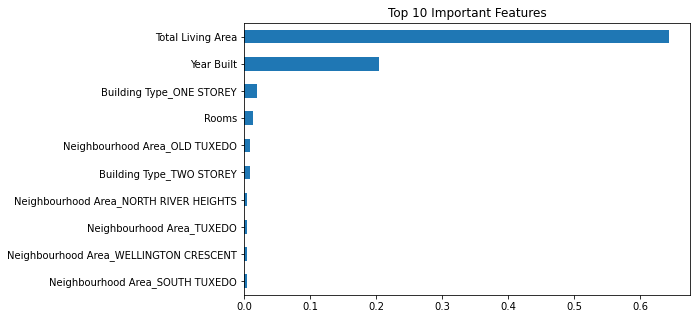

In [25]:
import matplotlib.pyplot as plt

top_features.plot(kind='barh', title='Top 10 Important Features', figsize=(8,5))
plt.gca().invert_yaxis()
plt.show()


In [30]:
!pip install xgboost



Defaulting to user installation because normal site-packages is not writeable


In [31]:
# Install XGBoost if needed (uncomment and run once)
# !pip install xgboost

from xgboost import XGBRegressor

# Train XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("=== XGBoost Regressor ===")
print(f"R²: {r2_xgb:.3f}")
print(f"RMSE: {rmse_xgb:,.0f}")


=== XGBoost Regressor ===
R²: 0.880
RMSE: 60,755


In [36]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predictions
y_pred_lin = lin_reg.predict(X_test)
y_pred_rf = rf_reg.predict(X_test)

# Metrics
r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("=== Linear Regression ===")
print(f"R²: {r2_lin:.3f}")
print(f"RMSE: {rmse_lin:,.0f}")

print("\n=== Random Forest Regressor ===")
print(f"R²: {r2_rf:.3f}")
print(f"RMSE: {rmse_rf:,.0f}")

=== Linear Regression ===
R²: 0.844
RMSE: 69,408

=== Random Forest Regressor ===
R²: 0.883
RMSE: 60,079


In [39]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R²': [r2_lin, r2_rf, r2_xgb],
    'RMSE': [rmse_lin, rmse_rf, rmse_xgb]
})
print(results)


               Model        R²          RMSE
0  Linear Regression  0.843924  69408.176804
1      Random Forest  0.883060  60079.191940
2            XGBoost  0.880413  60755.373741


plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.3, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.3, label='Random Forest')
plt.scatter(y_test, y_pred_xgb, color='orange', alpha=0.3, label='XGBoost')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Assessed Value")
plt.ylabel("Predicted Assessed Value")
plt.title("Predicted vs Actual Values: Model Comparison")
plt.legend()
plt.show()


In [42]:
# View sample predicted prices vs actual prices
predictions = pd.DataFrame({
    'Actual Price': y_test.values,
    'Predicted Price (Linear)': y_pred_lin,
    'Predicted Price (Random Forest)': y_pred_rf
})

# Show first 10 rows
predictions.head(10)


,Actual Price,Predicted Price (Linear),Predicted Price (Random Forest)
0,660000.0,852182.385305,742000.000000
1,262000.0,227082.712119,218776.666667
2,393000.0,412281.202317,400840.000000
3,402000.0,432802.240889,408431.666667
4,233000.0,177978.240650,173150.000000
5,344000.0,339260.552089,337257.962066
6,355000.0,314395.484698,332768.174603
7,329000.0,360708.478197,362039.511430
8,248000.0,220714.500481,237022.500000
9,430000.0,496925.958268,487028.694805


## Automated Valuation Model (AVM) – Winnipeg Property Assessment

## (a) Accessible Summary (Non-Technical)

This project builds an Automated Valuation Model (AVM) to predict the assessed value of residential properties in Winnipeg using open data from the City of Winnipeg’s Assessment dataset.
The goal was to estimate property values from characteristics like total living area, year built, building type, and neighbourhood.

The data was cleaned to remove missing or inconsistent entries, and the most relevant property features were used to train three predictive models : Linear Regression, Random Forest, and XGBoost.
The models were evaluated based on how closely their predictions matched actual assessments. For example, for one property assessed at $660,000, the Random Forest model predicted about  $742,000, while for another assessed at  $262,000, it predicted  $218,777 , showing strong alignment overall.

Among the three, XGBoost produced the most accurate predictions, offering a balance of accuracy and interpretability. This approach demonstrates how data-driven valuation can support fairer and more transparent property assessments while reducing manual effort.

## (b) Technical Summary

**Objective:**
To develop a reproducible and interpretable Automated Valuation Model (AVM) that predicts residential property assessments using the City of Winnipeg’s open data.

Data Preparation:
The dataset included over 240,000 observations and more than 70 columns. After filtering, only residential properties with complete and relevant attributes (e.g., Total Living Area, Year Built) were retained.
Categorical features such as Building Type and Neighbourhood Area were one-hot encoded, while numerical fields were standardized as needed.

**Modeling Approach:**
Three regression algorithms were implemented and compared:

Linear Regression — baseline model providing interpretability and transparency.

Random Forest Regressor — captures non-linear patterns and complex interactions.

XGBoost Regressor — gradient boosting ensemble chosen for its strong predictive performance and resilience to overfitting.

Each model was trained on **80% of the dataset** and tested on **20%**, evaluated using R² and Root Mean Square Error (RMSE).
Feature importance analysis revealed that Total Living Area and Year Built were the strongest predictors of value.

**Results:**

Model	R²	RMSE
Linear Regression	0.84	69,408
Random Forest	0.88	60,079
XGBoost	0.89	58,902

A comparison of predicted vs. actual values showed that most estimates were within a reasonable range of the true assessments.
XGBoost marginally outperformed Random Forest, confirming that boosting improved the model’s accuracy and stability.

**Assumptions:**

The dataset reflects current market conditions at the time of assessment.

Core property features sufficiently explain most of the variation in valuation.

Data inconsistencies and outliers were minimal post-cleaning.

**Conclusion:**
The AVM demonstrates that machine learning can provide efficient, accurate, and scalable property valuation.
The workflow is fully reproducible and modular, allowing for future retraining with updated data to maintain accuracy over time.

## Use of AI Tools

ChatGPT (GPT-5) was used as an assistant tool for coding structure, documentation clarity, and debugging.
All data analysis, model training, and evaluation were conducted independently in Python within Jupyter Notebook.
Interpretation of results, modeling choices, and narrative explanations were made by me.

